In [2]:
import torch
from builtins import range
from __future__ import division
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import classification_report, log_loss
from timeit import default_timer as timer
import gc
import sys
import skimage.transform as sktr
from torchvision.models import vgg11, alexnet
import torchvision
import sklearn.linear_model as lm
from sklearn.preprocessing import normalize
%matplotlib inline

/Users/penzardmitry/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 Задание: выкинуть последний слой из vgg / alexnet и обучить линейную регрессиию на выходах полученных сетей.
Например, для mnist.

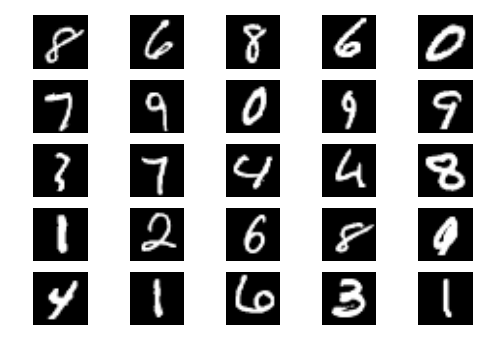

In [41]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)


images_train = images_train
labels_train = labels_train
images_test = images_test
labels_test = labels_test


for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')

In [42]:
alex_net = alexnet(pretrained=True)
print (alex_net.classifier)
print( alex_net.features)

Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)
Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)


In [48]:
#10, 3, 224, 224
def image_transform(img):
    img = np.squeeze(img)
    img = sktr.resize(img, (224, 224), preserve_range = True)
    img = np.repeat(img[np.newaxis, :,:], 3, axis = 0)
    return img

def process_mnist(img_arr):
    processed = np.zeros(shape = (img_arr.shape[0], 3, 224, 224))
    #sys.stdout.write("Start resizing images\n")
    for i in range(img_arr.shape[0]):
        #if i % 100 == 0:
            #sys.stdout.write("\rImage num {}".format(i))
        processed[i] = image_transform(img_arr[i])
    return processed
    #sys.stdout.write("\nDone\n")
    
    
def precompute_alex_features(X, batch_size = 50):
    sys.stdout.write("Start precomputing features\n")
    computed = np.zeros(shape = (X.shape[0], 9216))
    for ind, i in enumerate(range(0, X.shape[0], batch_size), 1):
        sys.stdout.write("\rBatch num {}".format(ind))
        sys.stdout.flush()
        batch = process_mnist(X[i:i+batch_size])
        batch = torch.from_numpy(batch).type(torch.FloatTensor)
        batch = Variable(batch, requires_grad = False)
        alex_train_features = alex_net.features.forward(batch)
        alex_train_features = alex_train_features.view(alex_train_features.size(0), -1)
        alex_train_features = alex_train_features.data.numpy()
        alex_train_features  = normalize(alex_train_features )
        computed[i:i+batch_size] = alex_train_features
    sys.stdout.write("\nDone\n")
    return computed

Сначала попробуем просто обработать данные MNIST  с помошью alexnet и затем научить на них логистическую регрессию
и пару простых нейронных сетей

In [49]:
#train_images_numpy = process_mnist(images_train)
#test_images_numpy = process_mnist(images_test)

print ("Computing train features")
images_train = precompute_alex_features(images_train)
print ("Computing test features")
images_test = precompute_alex_features(images_test)

Computing train features
Start precomputing features
Batch num 1050
Done
Computing test features
Start precomputing features
Batch num 350
Done


In [52]:

np.save('train_alex_processed.npy', images_train)
np.save('text_alex_processed.npy', images_test)

Попробуем логистическую регрессию

In [56]:
max_epoch_num = 15
batch_size = 50

model = lm.SGDClassifier(loss="log")
train_loss = list()
test_loss = list()

loss = None
classes = np.arange(10)
for epoch_num in range(max_epoch_num): 
    sys.stdout.write("Start epoch num : {}\n".format(epoch_num + 1))
    sys.stdout.write("  Training set\n")
    for ind, i in enumerate(range(0, len(images_train), batch_size), 1):
        sys.stdout.write("\r  ")
        sys.stdout.write("  Batch num {}, previous loss is {}".format(ind, loss))
        batch = images_train[i:(i+batch_size), :]
        labels = labels_train[i:(i+batch_size)]
        model.partial_fit(batch, labels, classes=classes)
        loss = log_loss(labels, model.predict_proba(batch), labels=classes)
        train_loss.append(loss)
    sys.stdout.write("\n  Done\n")
    sys.stdout.write("  Test set")
    for ind, i in enumerate(range(0, len(images_test), batch_size), 1):
        sys.stdout.write("\r  ")
        sys.stdout.write("  Batch num {}, previous loss is {}".format(ind, loss))
        batch = images_test[i:(i+batch_size), :]
        labels = labels_test[i:(i+batch_size)]
        loss = log_loss(labels, model.predict_proba(batch), labels=classes)
        test_loss.append(loss)
    sys.stdout.write("\n  Done\n")
    sys.stdout.write("Done\n")



Start epoch num : 1
  Training set
    Batch num 1050, previous loss is 0.377218810115
  Done
    Batch num 350, previous loss is 0.373188390951
  Done
Done
Start epoch num : 2
  Training set
    Batch num 1050, previous loss is 0.384492093737
  Done
    Batch num 350, previous loss is 0.365387342201
  Done
Done
Start epoch num : 3
  Training set
    Batch num 1050, previous loss is 0.391251166056
  Done
    Batch num 350, previous loss is 0.364537110804
  Done
Done
Start epoch num : 4
  Training set
    Batch num 1050, previous loss is 0.393545812406
  Done
    Batch num 350, previous loss is 0.361765657481
  Done
Done
Start epoch num : 5
  Training set
    Batch num 1050, previous loss is 0.395876505482
  Done
    Batch num 350, previous loss is 0.360216803561
  Done
Done
Start epoch num : 6
  Training set
    Batch num 1050, previous loss is 0.397613911132
  Done
    Batch num 350, previous loss is 0.35962044999
  Done
Done
Start epoch num : 7
  Training set
    Batch num 1050, prev

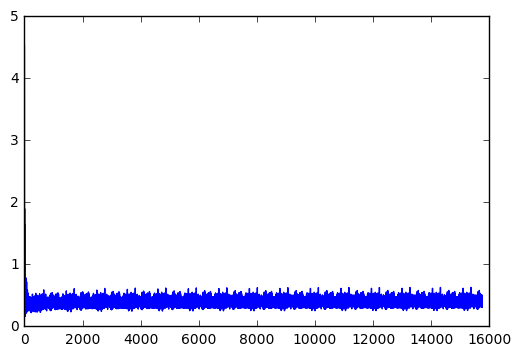

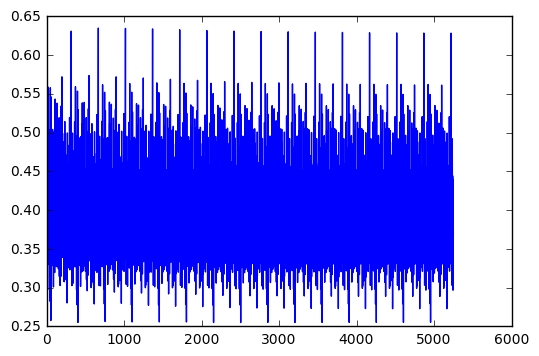

In [57]:


plt.plot(np.arange(len(train_loss)), np.array(train_loss))
plt.show()
plt.plot(np.arange(len(test_loss)), np.array(test_loss))
plt.show()

In [59]:
model.score(images_train, labels_train)

0.94904761904761903

In [61]:
model.score(images_test, labels_test)

0.9474285714285714

In [71]:
#26 * 26 
a = torch.LongTensor([1,2,3])
a.numpy()

array([1, 2, 3])

In [64]:
def Neuro_Arch():
    return nn.Sequential(
        nn.Linear(9216, 10)
    )

In [65]:
input_trans = nn.Linear(26 * 26, 224 * 224 * 3)
output_trans = nn.Linear(9216, 10)

In [83]:
#was copied from previous homework
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

@print_work_time
def learn_on_model(X, Y, model, loss_fn, X_test = None, Y_test = None, learning_rate = 1e-2, 
                   batch_size = 100, max_epoch_num = 1, min_loss = 1e-3): 



    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss = 1000
    epoch_num = 0
     
    loss_arr = list()

    test_loss_arr = list() if not (type(X_test) is None) else None
    tot_err = 10**6
    X = X.copy()
    Y = Y.copy()

    while tot_err > min_loss and epoch_num < max_epoch_num:
        model = model.eval()
        #perm = np.random.permutation(X.shape[0])
        #X = X[perm]
        #Y = Y[perm]
        tot_err = 0
        sys.stdout.write("Epoch {} ...\n".format(epoch_num + 1))
        for bn, start in enumerate(xrange(0, X.shape[0], batch_size)):
            optimizer.zero_grad()
            if bn % 100 == 0:
                sys.stdout.write("Train Batch {}\n".format(bn))
            X_CUR = Variable(torch.from_numpy(X[start:start + batch_size]).type(torch.FloatTensor),
                            requires_grad = True)
            Y_CUR = Variable(torch.from_numpy(Y[start:start + batch_size]), requires_grad=False)
            output =  model.forward(X_CUR)
            loss = loss_fn(output, Y_CUR)
            loss_arr.append(loss.data.tolist()[0])
            tot_err += loss
            loss.backward()
            optimizer.step()
            del loss
            del X_CUR
            del Y_CUR
            del output

        
        if not (type(X_test) is None):
            model = model.train()
            for bn, start in enumerate(xrange(0, X_test.shape[0], batch_size)):
                if bn % 100 == 0:
                    sys.stdout.write("Test Batch {}\n".format(bn))
                X_CUR = Variable(torch.from_numpy(X_test[start:start + batch_size]).type(torch.FloatTensor),
                                requires_grad = True)
                Y_CUR = Variable(torch.from_numpy(Y_test[start:start + batch_size]), requires_grad = False)
                y_pred = model.forward(X_CUR)
                loss = loss_fn(y_pred, Y_CUR)
                test_loss_arr.append(loss.data.tolist()[0])
                del X_CUR
                del Y_CUR
                del y_pred
                del loss
            
            
        epoch_num += 1
        gc.collect() # only this've helped to save process from beeing kill
    model = model.train()
    return np.array(loss_arr), np.array(test_loss_arr)

def draw_plots(model, loss_arr, layer_arr, test_loss_arr, show_weights = False):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    if show_weights:
        for ind1, child in enumerate(model.children()):
            for ind2, key in enumerate(child.state_dict().keys()):
                plotId += 1
                subpl = plt.subplot(gridSize, 1, plotId)
                y = layer_arr[ind1][ind2]
                subpl.plot(x, y)

                subpl.set_xticks(range(x.shape[0]))
                subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
                subpl.set_xlabel("Epoch num")
                subpl.set_ylabel(key + "_grad")
    
    plt.show()

from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, batch_size = 10):
    model = model.eval()
    print ("Train report")
    y_predicted = np.zeros(shape = (Y_TRAIN.size()[0], 10))
    
    for bn, start in enumerate(xrange(0, X_TRAIN.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TRAIN[start:start + batch_size])
        
        
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TRAIN.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TRAIN.tolist()) == indices))
    
    print ("Test report")
    y_predicted = np.zeros(shape = (Y_TEST.size()[0], 10))
    for bn, start in enumerate(xrange(0, X_TEST.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TEST[start:start + batch_size])
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
        del X_CUR
        
    
    
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TEST.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TEST.tolist()) == indices))

    


In [84]:
model = Neuro_Arch()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train,
                                          labels_train, 
                                          model, loss_fn,
                                          images_test,
                                          labels_test,\
                                          learning_rate,\
                                          max_epoch_num=15, 
                                          batch_size = 50)


Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 4 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Epoch 5 ...
Train Ba

In [ ]:

plt.plot(np.arange(len(train_loss)), np.array(train_loss))
plt.show()
plt.plot(np.arange(len(test_loss)), np.array(test_loss))
plt.show()

Теряем почти все временные преимущества дообучения сети. Попробуем просто ресайзить изображение с помощью skimage

In [41]:
import skimage.transform as sktr

In [71]:
a = sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224))
a = sktr.resize(a, (28,28) )

In [62]:
from skimage import data
image = data.camera()

In [92]:
((sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224, 3), preserve_range = True)) > 100).sum()

6594

In [84]:
?sktr.resize

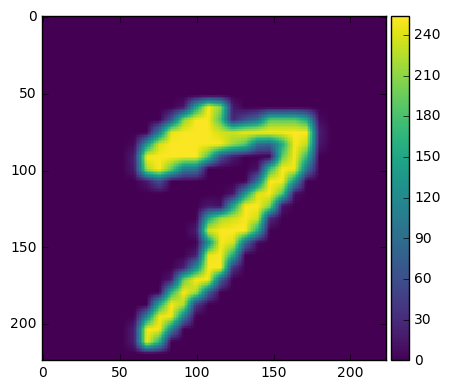

In [97]:
skimage.io.imshow(sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224), preserve_range = True))

In [91]:
?sktr.resize

In [98]:
a = sktr.resize(images_test[1].int().numpy().reshape(28,28), (224, 224), preserve_range = True)

In [110]:
images_test.size()

torch.Size([17500, 784])

In [126]:
img_arr = list()

for x in images_test.int().numpy():
    x = sktr.resize(x.reshape(28,28), (224, 224), preserve_range = True)
    x = np.repeat(a[:,:,np.newaxis], 3, axis = -1)

In [133]:
a = np.array(img_arr)

NameError: name 'img_arr' is not defined